# Convolutional Neural Network applied to Transient Detection

We star by reading the data

In [1]:
import numpy as np

pkl_data = np.load("data/HiTS_data.pkl", encoding='bytes')
#pkl_data = np.load("/Users/guille/Dropbox/git/Deep-HiTS/data/test_data/chunk_101_5000.pkl")
print(pkl_data.keys())
print(pkl_data[b'diff_images'].shape)


dict_keys([b'SNRs', b'RF_pbbs', b'features', b'temp_images', b'sci_images', b'labels', b'diff_images', b'SNR_images'])
(5026, 441)


Now we arrange the data so Keras can handle it

In [2]:
N_data = pkl_data[b'diff_images'].shape[0]
print(N_data)
X = np.array([pkl_data[b'temp_images'].reshape((N_data, 21, 21)), 
             pkl_data[b'sci_images'].reshape((N_data, 21, 21)),
             pkl_data[b'diff_images'].reshape((N_data, 21, 21)),
             pkl_data[b'SNR_images'].reshape((N_data, 21, 21))])
X = np.swapaxes(X, 0, 1)

Y = np.array([np.logical_not(pkl_data[b'labels']), pkl_data[b'labels']]).transpose()
print(X.shape, Y.shape)

5026
(5026, 4, 21, 21) (5026, 2)


In [3]:
a = np.array([[1,2,3],[4,5,6]])
print(a.transpose())
print(a.reshape ((3, 2)))

[[1 4]
 [2 5]
 [3 6]]
[[1 2]
 [3 4]
 [5 6]]


Let's plot a couple of stamps

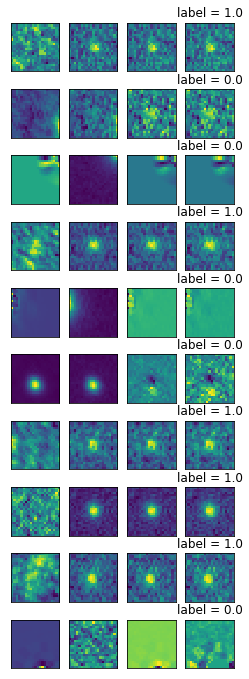

In [14]:
%matplotlib inline
import pylab as pl

N_plot = 10

pl.clf()
fig, axes = pl.subplots(N_plot, 4, figsize=(4, 12),
                        subplot_kw={'xticks': [], 'yticks': []})
for i in range(N_plot):
    axes.flat[4*i].imshow(X[i][0], interpolation = "none")
    axes.flat[4*i + 1].imshow(X[i][1], interpolation = "none")
    axes.flat[4*i + 2].imshow(X[i][2], interpolation = "none")
    axes.flat[4*i + 3].imshow(X[i][3], interpolation = "none")
    #axes.flat[4*i + 3].imshow(pkl_data['diff_images'][i].reshape((21, 21)), interpolation = "nearest")

    axes.flat[4*i + 3].set_title ("label = " + str(Y[i][1]))
pl.show()


We create a Keras sequential model

In [13]:
from IPython.display import SVG
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.vis_utils import plot_model, model_to_dot

# set dimensions ordering (depth as index 1)
import keras
keras.backend.set_image_dim_ordering('th')

model = Sequential ()
model.add(ZeroPadding2D((3, 3), input_shape = (4, 21, 21)))
model.add(Convolution2D(32, (4, 4)))
model.add(Activation('relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size =(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size =(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

Let's plot the model

To get this to plot, need to install (via pip --user or conda):
    
    1. graphviz
    2. pydot-ng

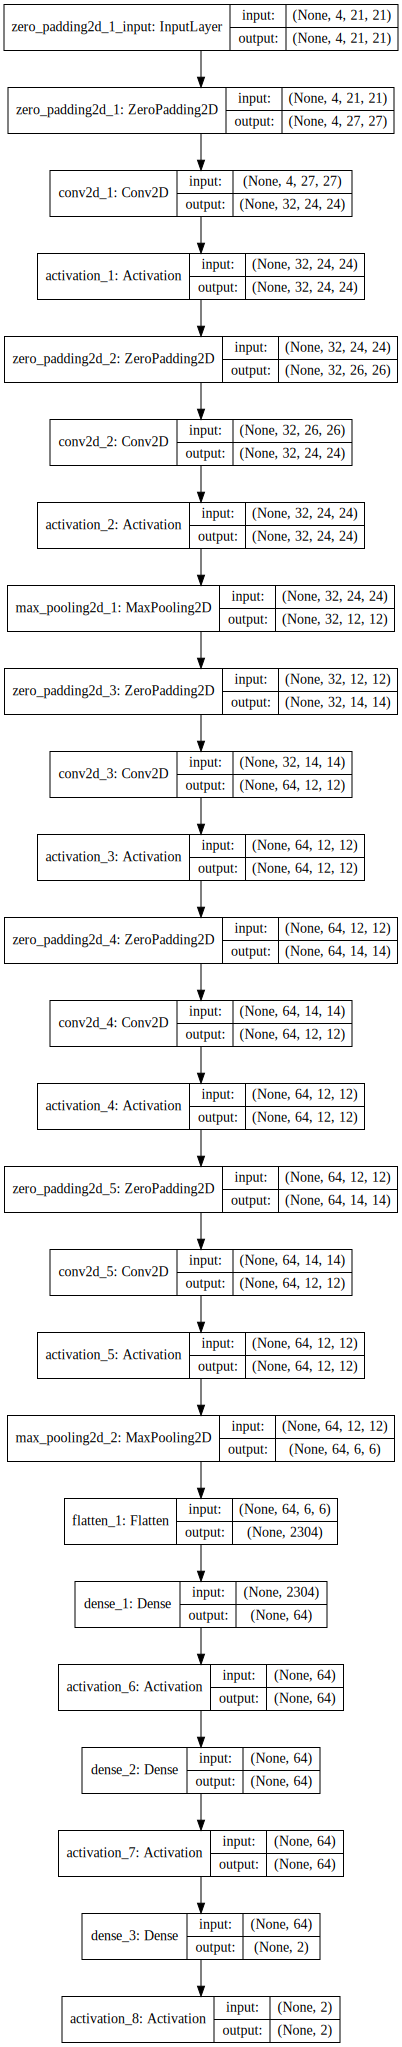

In [6]:
SVG(model_to_dot(model, show_shapes = True).create(prog='dot', format='svg'))

Compile the model

In [7]:
model.compile(loss='mean_squared_error',
              optimizer='sgd')

We split the data into training, and test set.

In [8]:
N_train = int(N_data * 0.9)

X_train, Y_train = X[:N_train], Y[:N_train]
X_test, Y_test = X[N_train:], Y[N_train:]

print("Train: ", X_train.shape, Y_train.shape)
print("Test: ", X_test.shape, Y_test.shape)

Train:  (4523, 4, 21, 21) (4523, 2)
Test:  (503, 4, 21, 21) (503, 2)


Now, we fit our model to the training data-set

In [9]:
model.fit(X_train, Y_train, batch_size=32, epochs=5, validation_split=0.2)

/Users/dreiss/miniconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 3618 samples, validate on 905 samples
Epoch 1/5
3618/3618 [==============================] - 26s - loss: 0.0848 - val_loss: 0.1290 
Epoch 2/5
3618/3618 [==============================] - 26s - loss: 0.0312 - val_loss: 0.0333
Epoch 3/5
3618/3618 [==============================] - 28s - loss: 0.0237 - val_loss: 0.0301
Epoch 4/5
3618/3618 [==============================] - 27s - loss: 0.0224 - val_loss: 0.0282
Epoch 5/5
3618/3618 [==============================] - 26s - loss: 0.0208 - val_loss: 0.0297


Now, lets predict on the test set

In [10]:
Y_pred = model.predict (X_test)

pbb_threshold = 0.5
pred_labels = np.array((Y_pred[:, 1] > pbb_threshold), dtype = "int")
print("Correctly classified ", (pred_labels == Y_test[:, 1].astype(int)).sum(), "out of", Y_test.shape[0])
print("accuracy = ", 1.*(pred_labels == Y_test[:, 1].astype(int)).sum() / Y_test.shape[0])


Correctly classified  500 out of 503
accuracy =  0.994035785288


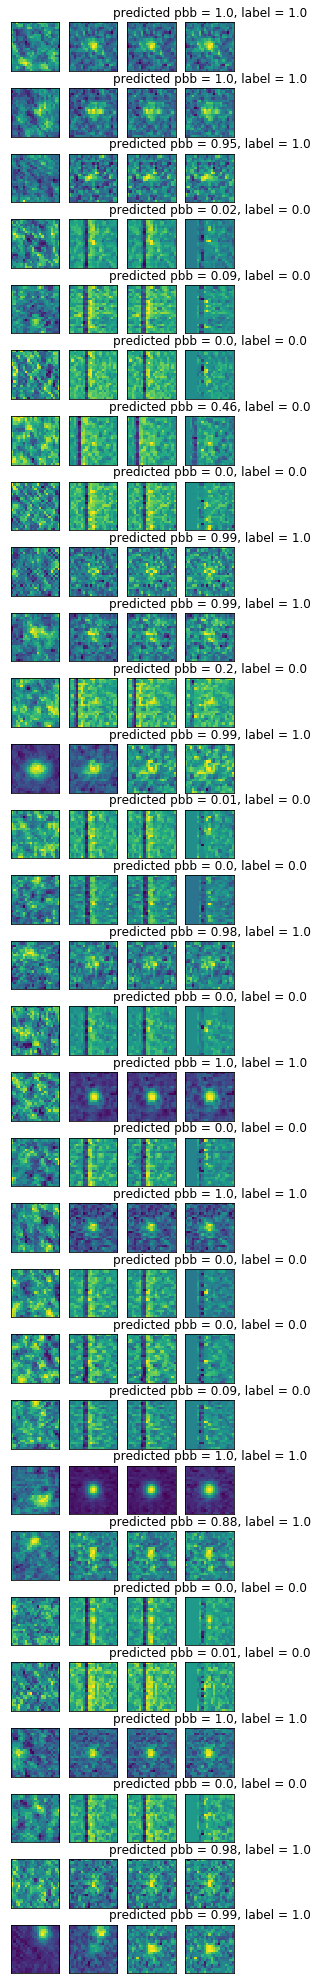

In [17]:
N_plot = 30

pl.clf()
fig, axes = pl.subplots(N_plot, 4, figsize=(4, 36),
                        subplot_kw={'xticks': [], 'yticks': []})
for i in range(N_plot):
    axes.flat[4*i].imshow(X_test[i][0], interpolation = "none")
    axes.flat[4*i + 1].imshow(X_test[i][1], interpolation = "none")
    axes.flat[4*i + 2].imshow(X_test[i][2], interpolation = "none")
    axes.flat[4*i + 3].imshow(X_test[i][3], interpolation = "none")
    #axes.flat[4*i + 3].imshow(pkl_data['diff_images'][i].reshape((21, 21)), interpolation = "nearest")

    axes.flat[4*i + 3].set_title ("predicted pbb = " + str(np.round(Y_pred[i][1], 2)) + 
                                  ", label = " + str(Y_test[i, 1]))
pl.show()